In [ ]:
!git clone https://github.com/Kashyap-Nirmal/Name_Dataset.git

Cloning into 'Name_Dataset'...
remote: Enumerating objects: 5001, done.
remote: Counting objects: 100% (5001/5001), done.
remote: Compressing objects: 100% (4993/4993), done.
remote: Total 5001 (delta 19), reused 4985 (delta 6), pack-reused 0
Receiving objects: 100% (5001/5001), 119.79 MiB | 35.10 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (9845/9845), done.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from numpy import asarray
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2
import os
import glob

In [ ]:
train_file = []
for filename in glob.glob(r"./Name_Dataset/Train/" + "/**/*", recursive=True): #assuming gif
    train_file.append(filename)

test_file = []
for filename in glob.glob(r"./Name_Dataset/Test/" + "/**/*", recursive=True): #assuming gif
    test_file.append(filename)

In [ ]:
random.shuffle(train_file)
print(len(train_file))
print(len(test_file))

3205
805


In [ ]:
label = {"Chris":0, "Jamie":1, "Maggie":2, "Stephen":3, "Tina": 4}

In [ ]:
trainx = []
testx = []
trainy = []
testy = []

for img in train_file:
  try:
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    trainx.append(image)

    lbl = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    l = label[lbl]
        
    trainy.append([l]) # [[1], [0], [0], ...]

  except:
    print("a")
    
for img in test_file:
  try:
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    testx.append(image)

    lbl = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    l = label[lbl]
        
    testy.append([l]) # [[1], [0], [0], ...]
  except:
    print("b")

a
a
a
a
a
b
b
b
b
b


In [ ]:
trainx = np.array(trainx, dtype="float")/255.0
testx = np.array(testx, dtype="float")/255.0

In [ ]:
trainy = np.array(trainy)
testy = np.array(testy)

In [ ]:
trainx.shape

(3200, 64, 64, 3)

In [ ]:
# # example of tending the vgg16 model
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import math

# load model without classifier layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

win1 = math.ceil(16/1)
str1 = math.floor(16/1)

win2 = math.ceil(16/2)
str2 = math.floor(16/2)

win3 = math.ceil(16/4)
str3 = math.floor(16/4)

l1 = keras.layers.MaxPooling2D(pool_size=(win1), strides=str1, padding="valid")(base_model.layers[-10].output)
l2 = keras.layers.MaxPooling2D(pool_size=(win2), strides=str2, padding="valid")(base_model.layers[-10].output)
l3 = keras.layers.MaxPooling2D(pool_size=(win3), strides=str3, padding="valid")(base_model.layers[-10].output)

flat1 = Flatten()(l1)
flat2 = Flatten()(l2)
flat3 = Flatten()(l3)

# # define new model

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.inputs, outputs=[flat1, flat2, flat3])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [ ]:
train_deep = model.predict(trainx)
test_deep = model.predict(testx)

In [ ]:
train_deep = np.hstack([train_deep[0], train_deep[1], train_deep[2]])
test_deep = np.hstack([test_deep[0], test_deep[1], test_deep[2]])

In [ ]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [ ]:
xgb_cl.fit(train_deep, trainy)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(objective='multi:softprob')

In [ ]:
y_pred = xgb_cl.predict(test_deep)
print("Accuracy:",metrics.accuracy_score(testy, y_pred))

Accuracy: 0.3275


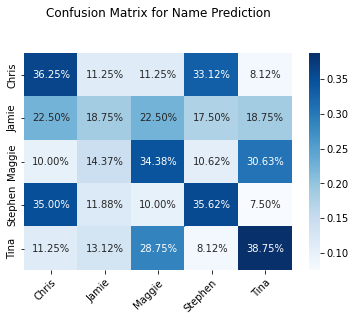

In [ ]:
confusionmatrix = confusion_matrix(testy, y_pred, normalize = 'true')  
ax = sns.heatmap(confusionmatrix , cmap = 'Blues', annot = True , cbar = True , fmt ='.2%')
ax.figbox
# Show all ticks and label them with the respective list entries
list = []
for key in label.keys():
  list.append(key)
ax.xaxis.set_ticklabels(list)
ax.yaxis.set_ticklabels(list) 
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels() , rotation=45 , ha="right", rotation_mode="anchor")
ax.set_title('Confusion Matrix for Name Prediction\n\n');
plt.show()

In [ ]:
print(classification_report(testy, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.36      0.34       160
           1       0.27      0.19      0.22       160
           2       0.32      0.34      0.33       160
           3       0.34      0.36      0.35       160
           4       0.37      0.39      0.38       160

    accuracy                           0.33       800
   macro avg       0.32      0.33      0.32       800
weighted avg       0.32      0.33      0.32       800

